# The IQ-OTH/NCCD lung cancer dataset
## Lung Cancer CT Scans from Iraqi hospitals: Normal, Benign, and Malignant Cases

## About Dataset
The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU and window center from 50 to 600 were used for reading. with breath hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.

if you use this dataset you should cite the following articles:

1- Diagnosis of lung cancer based on CT scans using CNN
can be cited as :
(H. F. Al-Yasriy, M. S. Al-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, "Diagnosis of Lung Cancer Based on CT Scans Using CNN," IOP Conference Series: Materials Science and Engineering, vol. 928, 2020.)

2- Evaluation of SVM performance in the detection of lung cancer in marked CT scan dataset
can be cited as:
(H. F. Kareem, M. S. A.-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, “Evaluation of SVM performance in the detection
of lung cancer in marked CT scan dataset,” Indonesian Journal of Electrical Engineering and Computer Science, vol. 21, no. 3,
pp. 1731-1738, 2021, doi: 10.11591/ijeecs.v21.i3.pp1731-1738.)

3- The IQ-OTH/NCCD lung cancer dataset
can be cited as :
(alyasriy, hamdalla; AL-Huseiny, Muayed (2023), “The IQ-OTH/NCCD lung cancer dataset”, Mendeley Data, V4, doi: 10.17632/bhmdr45bh2.4)

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NearMiss
from sklearn.utils.class_weight import compute_class_weight
import torch
from vit_pytorch.simple_vit_with_patch_dropout import SimpleViT
from vit_pytorch.extractor import Extractor
from coca_pytorch.coca_pytorch import CoCa
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
pd.set_option('display.max_colwidth', None)

In [3]:
directory = r"lung_cancer_dataset"
categories = ["Bengin cases", "Malignant cases", "Normal cases"]

benign_directory = directory + "/" + categories[0]
malignant_directory = directory + "/" + categories[1]
normal_directory = directory + "/" + categories[2]

# saving the path of all data in dictionary
path_list = []
category_list = []
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list.append(image_file_path)
        category_list.append(category)

path_series = pd.Series(path_list, name="filepath")
category_series = pd.Series(category_list, name="category")

image_paths_df = pd.DataFrame(path_series).join(category_series)

#image_paths_df.head()        

# Image resizing

In [5]:
# read image size and put it into dataframe
size_data = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    #plt.imshow(cv2.imread(image_file_path, is_grayscale))
    #plt.show()
    size_data[category] = image_sizes_in_one_category
size_data_df = pd.DataFrame(size_data)
#print(size_data)
#size_data_df.head(10)

In [6]:
dataset = []
desired_size = 256
for index, row in image_paths_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset.append([img, label])
    
random.shuffle(dataset)

#print(dataset[0][1])
#plt.imshow(dataset[0][0])
#plt.show()

# Image smoothing

In [8]:
# using gaussian blur
#kernel_shape = 3
#for data in dataset:
#    img = cv2.GaussianBlur(data[0], (kernel_shape, kernel_shape), 0)
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [9]:
# using bilateral filtering
diameter = 3
sigma_color = 25
sigma_space = 25
for data in dataset:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [10]:
# using 2d convolution
#kernel_size = 5
#kernel_ = np.ones((kernel_size, kernel_size), np.float32)/(kernel_size*kernel_size)
#for data in dataset:
#    img = cv2.filter2D(src=data[0], ddepth=-1, kernel=kernel_)
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

# Data normalization

In [12]:
# using min-max scaling
for data in dataset:
    img = data[0]/255.0
    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [13]:
# using standardization
#for data in dataset:
#    mean, std = cv2.meanStdDev(data[0])
#    img = (data[0] - mean) / std
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

# Data splitting

In [15]:
x, y = [], []
for image, category in dataset:
    x.append(image)
    y.append(category)

x = np.array(x)
y = np.array(y)

x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2, random_state = 15, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.33, random_state = 15, stratify=y)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# apply one-hot encoding

y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

y_test_labels = np.argmax(y_test, axis=1)

for i in range(0, len(label_encoder.classes_)):
    print(i, end="")
    print(" = ", end="")
    print(label_encoder.classes_[i])

0 = Bengin cases
1 = Malignant cases
2 = Normal cases


# Handling data imbalance

In [17]:
# using SMOTE (like example)
print(x_train.shape)
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)
print(x_train.shape)

print("before: ", Counter(y_train))

sample_nums = max(Counter(y_train).values()) * 2
sampling_strategy = {1: sample_nums, 2: sample_nums, 0: sample_nums}

x_train_smt, y_train_smt = SMOTE(sampling_strategy=sampling_strategy, random_state=42).fit_resample(x_train, y_train)

print("after: ", Counter(y_train_smt))
x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_smt = x_train_smt.reshape(x_train_smt.shape[0], desired_size, desired_size, 1)
print(x_train.shape)
print(x_train_smt.shape)

y_train_smt = to_categorical(y_train_smt, num_classes=3)

(587, 256, 256)
(587, 65536)
before:  Counter({1: 300, 2: 223, 0: 64})
after:  Counter({1: 600, 2: 600, 0: 600})
(587, 256, 256, 1)
(1800, 256, 256, 1)


In [28]:
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)

# Initialize SMOTE and ENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

# Apply SMOTEENN to resample the training data
x_train_hybrid, y_train_hybrid = smote_enn.fit_resample(x_train, y_train)

x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_hybrid = x_train_hybrid.reshape(x_train_hybrid.shape[0], desired_size, desired_size, 1)

y_train_hybrid = to_categorical(y_train_hybrid, num_classes=3)

# Check the new class distribution
print("After Hybrid Resampling:")
print(f"Counts of label '0': {np.sum(y_train_hybrid[:, 0])}")
print(f"Counts of label '1': {np.sum(y_train_hybrid[:, 1])}")
print(f"Counts of label '2': {np.sum(y_train_hybrid[:, 2])}")

After Hybrid Resampling:
Counts of label '0': 296.0
Counts of label '1': 280.0
Counts of label '2': 277.0


In [44]:
# using near miss algorithm -> don't use, result is bad
print("Before Undersampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)

nr = NearMiss()

x_train_miss, y_train_miss = nr.fit_resample(x_train, y_train.ravel())

x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_miss = x_train_miss.reshape(x_train_miss.shape[0], desired_size, desired_size, 1)

y_train_miss = to_categorical(y_train_miss, num_classes=3)

print('After Undersampling, the shape of train_x: {}'.format(x_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '2': {}".format(np.sum(y_train_miss[:, 2])))
print("After Undersampling, counts of label '1': {}".format(np.sum(y_train_miss[:, 1])))
print("After Undersampling, counts of label '0': {}".format(np.sum(y_train_miss[:, 0])))

Before Undersampling, counts of label '2': 223
Before Undersampling, counts of label '1': 300
Before Undersampling, counts of label '0': 64 

After Undersampling, the shape of train_x: (192, 256, 256, 1)
After Undersampling, the shape of train_y: (192, 3) 

After Undersampling, counts of label '2': 64.0
After Undersampling, counts of label '1': 64.0
After Undersampling, counts of label '0': 64.0


# Data models

In [18]:
def all_evaluation(y_test_labels, y_pred_labels, model, epoch_num, batch):
    output_path = 'output\\' + model + '_epoch' + str(epoch_num) + '_batch' + str(batch)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Accuracy, precision, recall, f1 score
    print(metrics.classification_report(y_test_labels, y_pred_labels, digits=4))
    report = metrics.classification_report(y_test_labels, y_pred_labels, digits=4)
    cm = metrics.confusion_matrix(y_test_labels, y_pred_labels)
    
    print(f"The Cohen's Kappa Score is: {metrics.cohen_kappa_score(y_test_labels, y_pred_labels)}")
    cohen = metrics.cohen_kappa_score(y_test_labels, y_pred_labels)
    with open(output_path + '\\evaluation_report.txt', 'w') as f:
        f.write(report)
        f.write('\n')
        f.write('The Cohen\'s Kappa Score is: ' + str(cohen))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Bengin', 'Malignant', 'Normal'],
                yticklabels=['Bengin', 'Malignant', 'Normal'])
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.savefig(output_path + '\\confusion_matrix.jpg')
    plt.show()

### Using CNN

C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,969,283 (57.10 MB)

 Trainable params: 14,969,283 (57.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5104 - loss: 0.9772 - val_accuracy: 0.9345 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9588 - loss: 0.1222 - val_accuracy: 0.9310 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9821 - loss: 0.0650 - val_accuracy: 0.9552 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9864 - loss: 0.0383 - val_accuracy: 0.9586 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9621 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9908 - loss: 0.0515 - val_accuracy: 0.9690 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9920 - loss: 0.

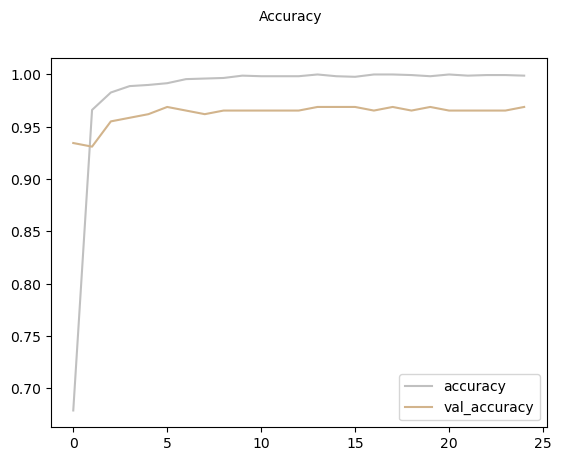

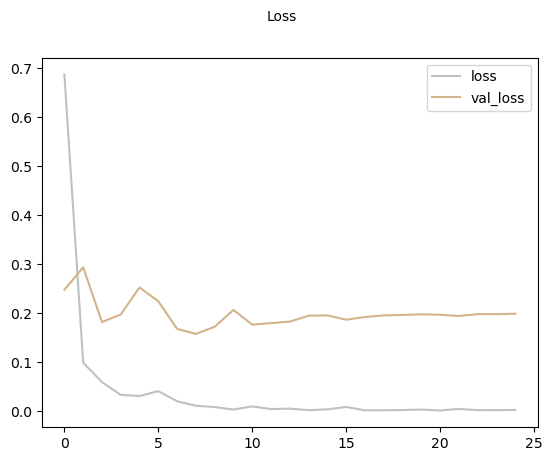

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 912ms/step
              precision    recall  f1-score   support

           0     0.9565    0.9167    0.9362        24
           1     0.9912    0.9912    0.9912       113
           2     0.9762    0.9880    0.9820        83

    accuracy                         0.9818       220
   macro avg     0.9746    0.9653    0.9698       220
weighted avg     0.9817    0.9818    0.9817       220

The Cohen's Kappa Score is: 0.9686910733980859


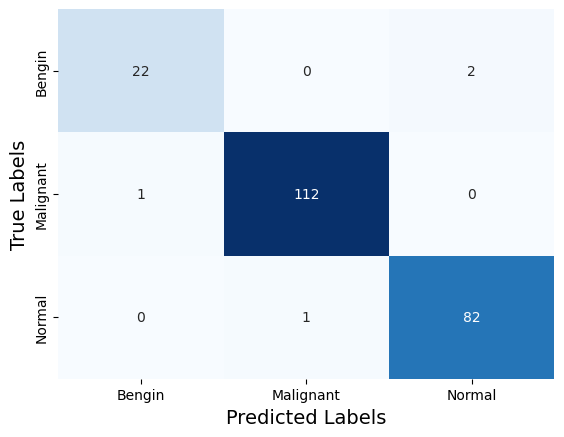

CPU times: total: 11h 17min 45s
Wall time: 1h 38min 50s


In [22]:
%%time

model_name = 'cnn'
epoch_num = 25
batch = 16

# cnn model
def build_model_cnn(optimizer="adam", dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(x_train_smt.shape[1:])))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    return model

model_cnn = build_model_cnn()
model_cnn.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_cnn = model_cnn.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_cnn.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='silver', label='loss')
plt.plot(history_cnn.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_cnn.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using ResNet 50 V2

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 25,670,147 (97.92 MB)

 Trainable params: 5,519,363 (21.05 MB)

 Non-trainable params: 20,150,784 (76.87 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.7879 - loss: 0.6753 - val_accuracy: 0.8862 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9837 - loss: 0.0454 - val_accuracy: 0.8586 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9586 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9655 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.9988 - loss: 0.0029 - val_accuracy: 0.9655 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 1.0000 - loss: 8.3539e-04 - val_accuracy: 0.9517 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 1.0000 - loss: 8.4978e-04 -

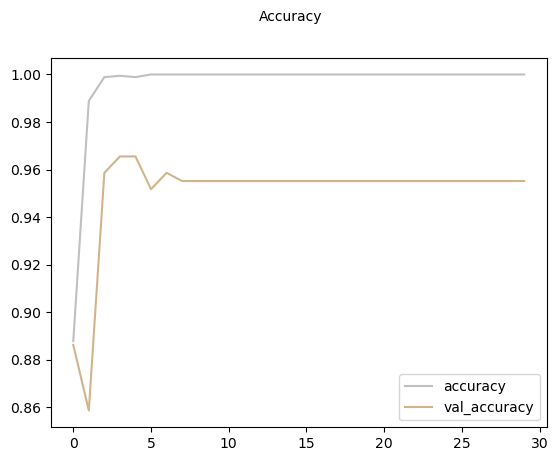

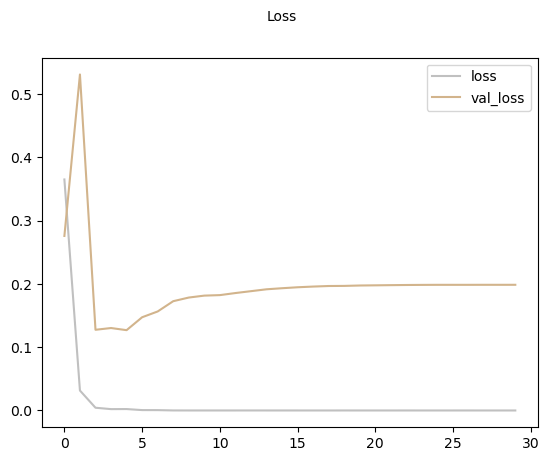

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
              precision    recall  f1-score   support

           0     1.0000    0.7083    0.8293        24
           1     1.0000    1.0000    1.0000       113
           2     0.9222    1.0000    0.9595        83

    accuracy                         0.9682       220
   macro avg     0.9741    0.9028    0.9296       220
weighted avg     0.9707    0.9682    0.9661       220

The Cohen's Kappa Score is: 0.9445105033690051


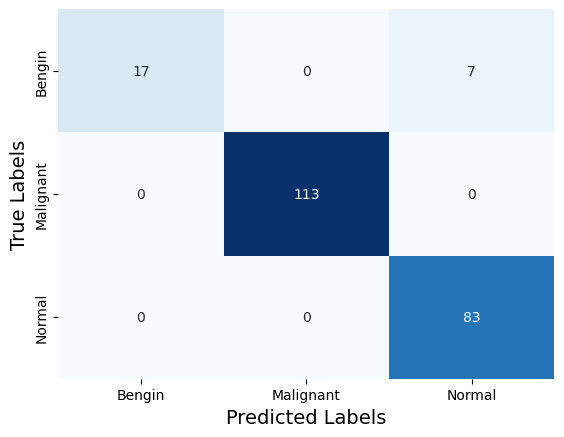

CPU times: total: 4h 15min 34s
Wall time: 1h 4min 6s


In [31]:
%%time
model_name = 'resnet50v2'
epoch_num = 30
batch = 64
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

def build_model_ResNet50V2():
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_resnet50v2 = build_model_ResNet50V2()
model_resnet50v2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_resnet50v2 = model_resnet50v2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_resnet50v2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_resnet50v2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_resnet50v2.history['loss'], color='silver', label='loss')
plt.plot(history_resnet50v2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_resnet50v2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### EfficientNetV2 variations

#### EfficientNetV2B0

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_13[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_co… │ (None, None,      │      4,096 │ block2b_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_bn  │ (None, None,      │        128 │ block2b_project_

 Total params: 7,238,227 (27.61 MB)

 Trainable params: 1,898,547 (7.24 MB)

 Non-trainable params: 5,339,680 (20.37 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 338ms/step - accuracy: 0.6927 - loss: 1.1431 - val_accuracy: 0.8621 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 310ms/step - accuracy: 0.8703 - loss: 0.3642 - val_accuracy: 0.9276 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 315ms/step - accuracy: 0.8999 - loss: 0.2847 - val_accuracy: 0.9655 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 312ms/step - accuracy: 0.9363 - loss: 0.1792 - val_accuracy: 0.9448 - val_loss: 0.1779 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 317ms/step - accuracy: 0.9590 - loss: 0.1247 - val_accuracy: 0.9517 - val_loss: 0.1775 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 315ms/step - accuracy: 0.9590 - loss: 0.1256 - val_accuracy: 0.9586 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 315ms/step - accuracy: 0.9

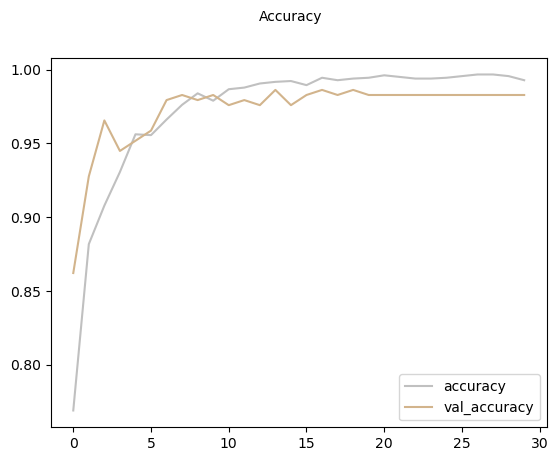

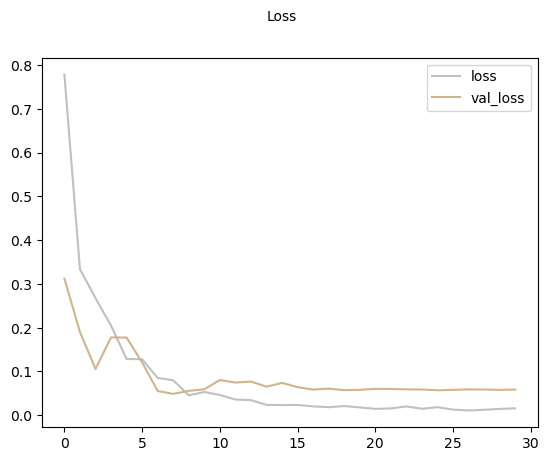

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step
              precision    recall  f1-score   support

           0     0.9583    0.9583    0.9583        24
           1     1.0000    0.9912    0.9956       113
           2     0.9762    0.9880    0.9820        83

    accuracy                         0.9864       220
   macro avg     0.9782    0.9791    0.9786       220
weighted avg     0.9865    0.9864    0.9864       220

The Cohen's Kappa Score is: 0.9765924244573698


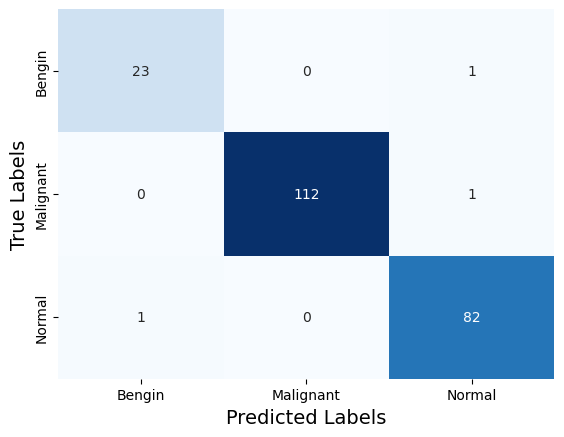

CPU times: total: 4min 44s
Wall time: 18min 24s


In [59]:
%%time

from tensorflow.keras.applications import EfficientNetV2B0

model_name = 'EfficientNetV2B0'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()


def build_model_EfficientNetV2B0():
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B0 = build_model_EfficientNetV2B0()
model_EfficientNetV2B0.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B0 = model_EfficientNetV2B0.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B0.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B0.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B0.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B1

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_14[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 8,250,039 (31.47 MB)

 Trainable params: 1,898,547 (7.24 MB)

 Non-trainable params: 6,351,492 (24.23 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 376ms/step - accuracy: 0.6533 - loss: 1.3874 - val_accuracy: 0.8931 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.8243 - loss: 0.5100 - val_accuracy: 0.9448 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.8696 - loss: 0.3865 - val_accuracy: 0.9379 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 352ms/step - accuracy: 0.8999 - loss: 0.2751 - val_accuracy: 0.9207 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 352ms/step - accuracy: 0.9300 - loss: 0.1946 - val_accuracy: 0.9586 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.9548 - loss: 0.1420 - val_accuracy: 0.9448 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.9

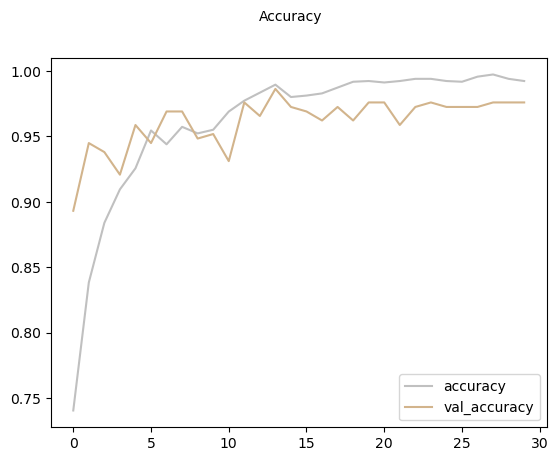

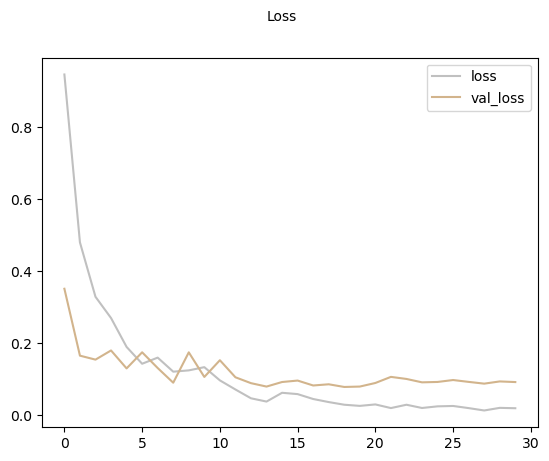

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 695ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        24
           1     1.0000    1.0000    1.0000       113
           2     0.9765    1.0000    0.9881        83

    accuracy                         0.9909       220
   macro avg     0.9922    0.9722    0.9815       220
weighted avg     0.9911    0.9909    0.9908       220

The Cohen's Kappa Score is: 0.984312606959498


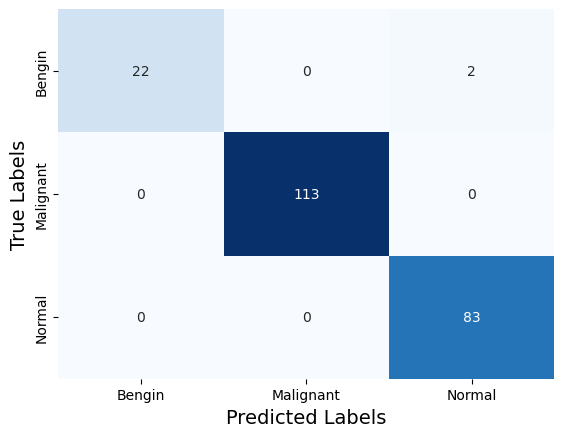

CPU times: total: 6min 35s
Wall time: 20min 22s


In [60]:
%%time

from tensorflow.keras.applications import EfficientNetV2B1

model_name = 'EfficientNetV2B1'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B1():
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B1 = build_model_EfficientNetV2B1()
model_EfficientNetV2B1.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B1 = model_EfficientNetV2B1.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B1.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B1.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B2

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_15[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 10,219,361 (38.98 MB)

 Trainable params: 2,134,711 (8.14 MB)

 Non-trainable params: 8,084,650 (30.84 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 336ms/step - accuracy: 0.6564 - loss: 1.4642 - val_accuracy: 0.8862 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - accuracy: 0.8354 - loss: 0.4948 - val_accuracy: 0.9000 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - accuracy: 0.8799 - loss: 0.3438 - val_accuracy: 0.9069 - val_loss: 0.2945 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - accuracy: 0.9002 - loss: 0.2623 - val_accuracy: 0.9379 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - accuracy: 0.9208 - loss: 0.2060 - val_accuracy: 0.9586 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - accuracy: 0.9290 - loss: 0.2206 - val_accuracy: 0.9483 - val_loss: 0.1477 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - accuracy: 0.9

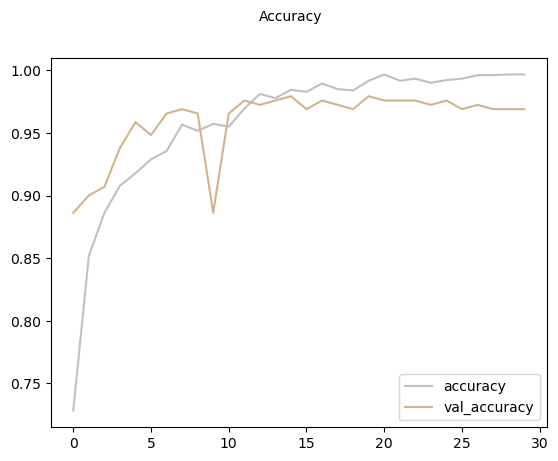

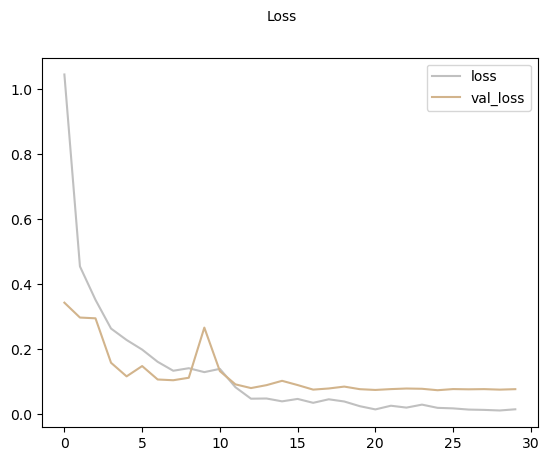

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step
              precision    recall  f1-score   support

           0     0.9545    0.8750    0.9130        24
           1     0.9912    1.0000    0.9956       113
           2     0.9643    0.9759    0.9701        83

    accuracy                         0.9773       220
   macro avg     0.9700    0.9503    0.9596       220
weighted avg     0.9771    0.9773    0.9770       220

The Cohen's Kappa Score is: 0.9607395245913342


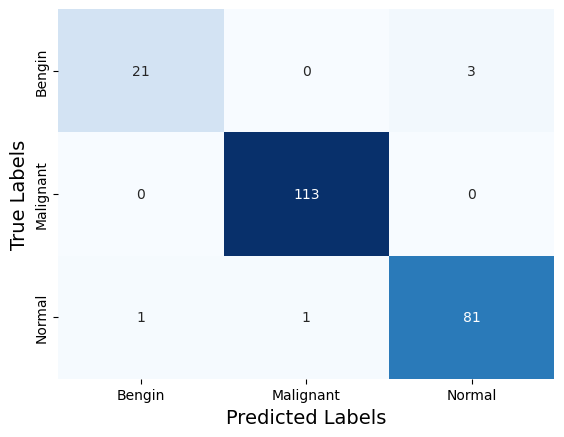

CPU times: total: 7min 24s
Wall time: 17min 29s


In [61]:
%%time

from tensorflow.keras.applications import EfficientNetV2B2

model_name = 'EfficientNetV2B2'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B2():
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B2 = build_model_EfficientNetV2B2()
model_EfficientNetV2B2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B2 = model_EfficientNetV2B2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B3

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ input_layer_16[0… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,760 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,560 │ block2a_expand_a… │
│ (Conv2D)            │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        160 │ block2a_project_

 Total params: 14,511,681 (55.36 MB)

 Trainable params: 2,424,765 (9.25 MB)

 Non-trainable params: 12,086,916 (46.11 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 79s 551ms/step - accuracy: 0.5993 - loss: 1.4774 - val_accuracy: 0.8379 - val_loss: 0.4327 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.8091 - loss: 0.5467 - val_accuracy: 0.8621 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 514ms/step - accuracy: 0.8679 - loss: 0.4184 - val_accuracy: 0.9000 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.8917 - loss: 0.3172 - val_accuracy: 0.9207 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.9099 - loss: 0.2397 - val_accuracy: 0.9586 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.9464 - loss: 0.1657 - val_accuracy: 0.9448 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.9

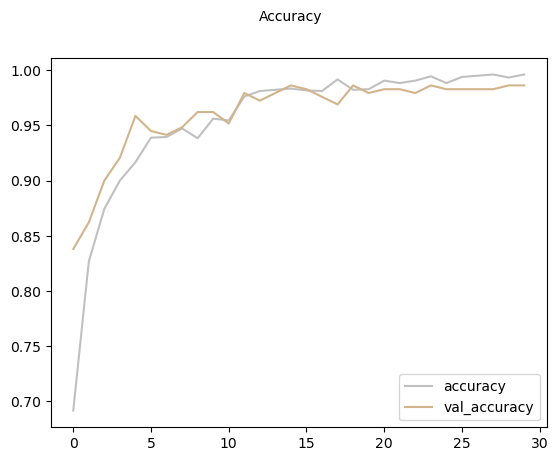

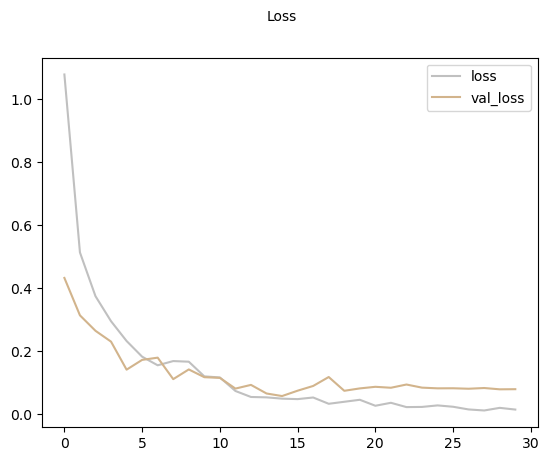

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 875ms/step
              precision    recall  f1-score   support

           0     0.9565    0.9167    0.9362        24
           1     0.9912    1.0000    0.9956       113
           2     0.9759    0.9759    0.9759        83

    accuracy                         0.9818       220
   macro avg     0.9746    0.9642    0.9692       220
weighted avg     0.9817    0.9818    0.9817       220

The Cohen's Kappa Score is: 0.9686576201161092


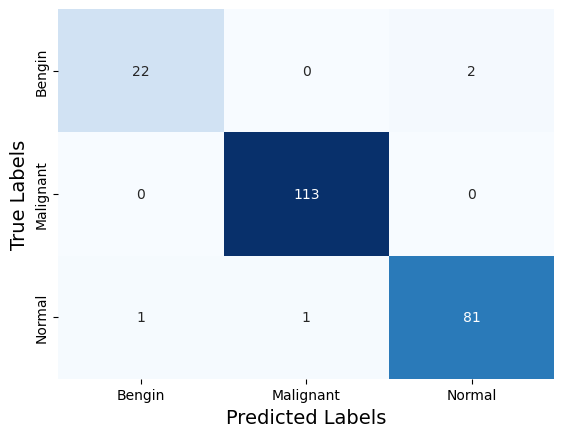

CPU times: total: 10min 9s
Wall time: 28min 56s


In [64]:
%%time

from tensorflow.keras.applications import EfficientNetV2B3

model_name = 'EfficientNetV2B3'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B3():
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B3 = build_model_EfficientNetV2B3()
model_EfficientNetV2B3.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B3 = model_EfficientNetV2B3.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B3.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B3.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B3.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using InceptionResNetV2

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_6[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 55,917,795 (213.31 MB)

 Trainable params: 5,709,795 (21.78 MB)

 Non-trainable params: 50,208,000 (191.53 MB)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - accuracy: 0.6747 - loss: 1.0148 - val_accuracy: 0.7103 - val_loss: 0.8778 - learning_rate: 0.0010
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 326s 11s/step - accuracy: 0.8726 - loss: 0.3700 - val_accuracy: 0.7621 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - accuracy: 0.9523 - loss: 0.1439 - val_accuracy: 0.7552 - val_loss: 0.8314 - learning_rate: 0.0010
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 324s 11s/step - accuracy: 0.9700 - loss: 0.0769 - val_accuracy: 0.8862 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 331s 11s/step - accuracy: 0.9843 - loss: 0.0408 - val_accuracy: 0.8517 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - accuracy: 0.9728 - loss: 0.0595 - val_accuracy: 0.8276 - val_loss: 0.6554 - learning_rate: 0.0010
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 329s 11s/step - accuracy: 0.9713 - loss: 0.0761 - 

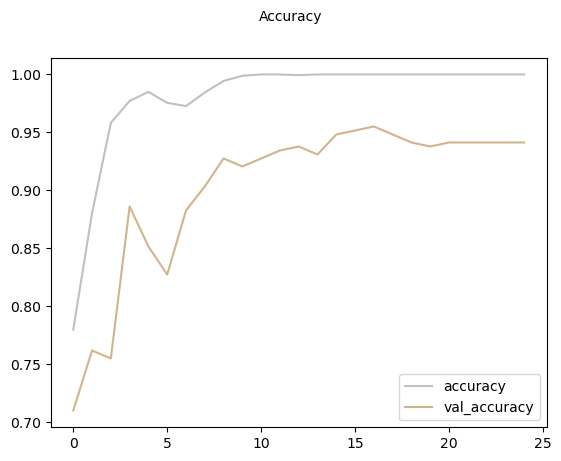

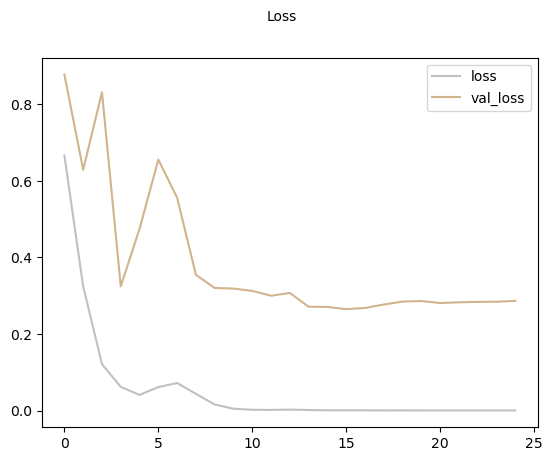

7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step
              precision    recall  f1-score   support

           0     0.8824    0.6250    0.7317        24
           1     1.0000    0.9823    0.9911       113
           2     0.8804    0.9759    0.9257        83

    accuracy                         0.9409       220
   macro avg     0.9209    0.8611    0.8828       220
weighted avg     0.9421    0.9409    0.9381       220

The Cohen's Kappa Score is: 0.8971703879480819


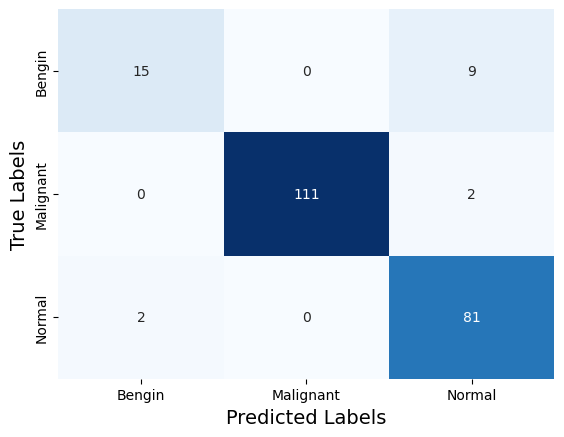

CPU times: total: 9h 58min 20s
Wall time: 2h 17min 46s


In [33]:
%%time
from tensorflow.keras.applications import InceptionResNetV2

#15 or 25
model_name = 'inceptionresnetv2'
epoch_num = 25
batch = 64
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (299, 299)).numpy()
x_val = tf.image.resize(x_val, (299, 299)).numpy()
x_test = tf.image.resize(x_test, (299, 299)).numpy()


def build_model_inceptionresnetv2():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_inceptionresnetv2 = build_model_inceptionresnetv2()
model_inceptionresnetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_inceptionresnetv2 = model_inceptionresnetv2.fit(x_train_smt, y_train_smt,batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_inceptionresnetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['loss'], color='silver', label='loss')
plt.plot(history_inceptionresnetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_inceptionresnetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using NasNetMobile

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_203[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_204[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_206[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_205[0

 Total params: 5,359,255 (20.44 MB)

 Trainable params: 1,087,843 (4.15 MB)

 Non-trainable params: 4,271,412 (16.29 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 635ms/step - accuracy: 0.6864 - loss: 0.9406 - val_accuracy: 0.8276 - val_loss: 0.4317 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - accuracy: 0.9109 - loss: 0.2541 - val_accuracy: 0.8621 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.9410 - loss: 0.1662 - val_accuracy: 0.8966 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 532ms/step - accuracy: 0.9632 - loss: 0.1013 - val_accuracy: 0.9034 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9761 - loss: 0.0842 - val_accuracy: 0.8897 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 517ms/step - accuracy: 0.9641 - loss: 0.0980 - val_accuracy: 0.9172 - val_loss: 0.2952 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.9794 - loss: 0.

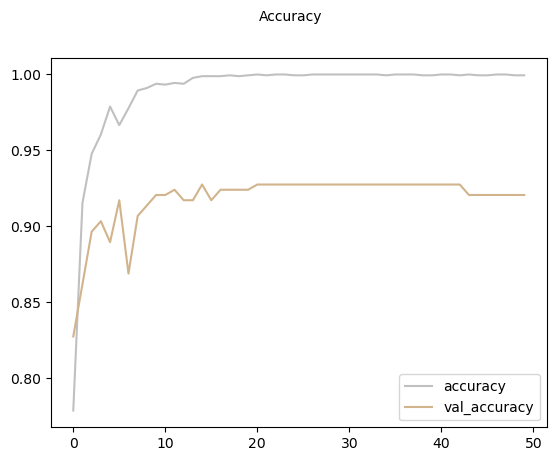

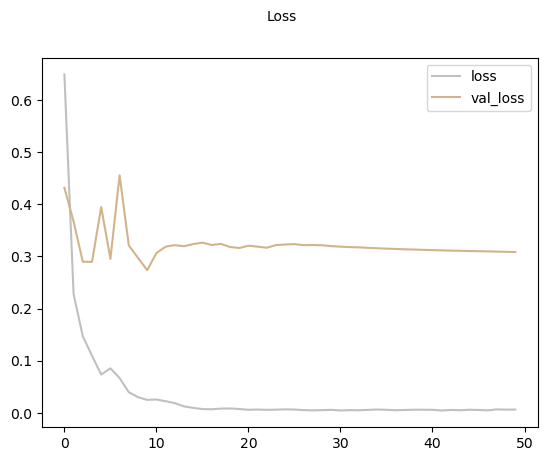

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 
              precision    recall  f1-score   support

           0     0.8125    0.5417    0.6500        24
           1     0.9818    0.9558    0.9686       113
           2     0.8511    0.9639    0.9040        83

    accuracy                         0.9136       220
   macro avg     0.8818    0.8204    0.8409       220
weighted avg     0.9140    0.9136    0.9095       220

The Cohen's Kappa Score is: 0.8495536999712064


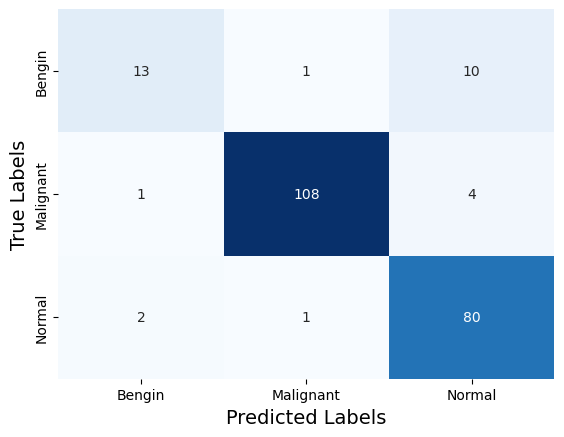

CPU times: total: 1h 11min 33s
Wall time: 24min


In [34]:
%%time
from tensorflow.keras.applications import NASNetMobile

model_name = 'nasnetmobile'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_nasnetmobile():
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_nasnetmobile = build_model_nasnetmobile()
model_nasnetmobile.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_nasnetmobile = model_nasnetmobile.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_nasnetmobile.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_nasnetmobile.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_nasnetmobile.history['loss'], color='silver', label='loss')
plt.plot(history_nasnetmobile.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_nasnetmobile.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### MobileNetV2

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,899 (13.64 MB)

 Trainable params: 2,049,347 (7.82 MB)

 Non-trainable params: 1,527,552 (5.83 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 347ms/step - accuracy: 0.7700 - loss: 0.7149 - val_accuracy: 0.7000 - val_loss: 2.8221 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.9121 - loss: 0.1975 - val_accuracy: 0.6931 - val_loss: 5.3275 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - accuracy: 0.9525 - loss: 0.1158 - val_accuracy: 0.6138 - val_loss: 8.3231 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.9752 - loss: 0.0776 - val_accuracy: 0.5759 - val_loss: 8.1329 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 300ms/step - accuracy: 0.9844 - loss: 0.0426 - val_accuracy: 0.6828 - val_loss: 5.3781 - learning_rate: 5.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 387ms/step - accuracy: 0.9963 - loss: 0.0140 - val_accuracy: 0.7655 - val_loss: 4.4234 - learning_rate: 5.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - accur

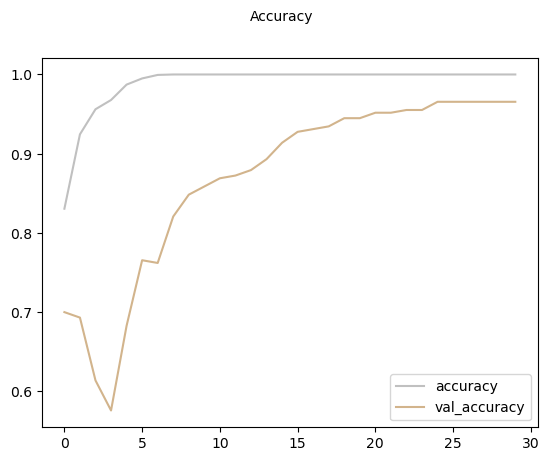

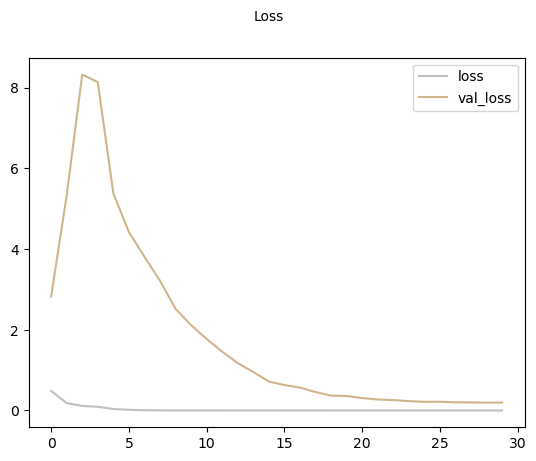

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step
              precision    recall  f1-score   support

           0     0.8800    0.9167    0.8980        24
           1     1.0000    1.0000    1.0000       113
           2     0.9756    0.9639    0.9697        83

    accuracy                         0.9773       220
   macro avg     0.9519    0.9602    0.9559       220
weighted avg     0.9777    0.9773    0.9774       220

The Cohen's Kappa Score is: 0.9610274579273693


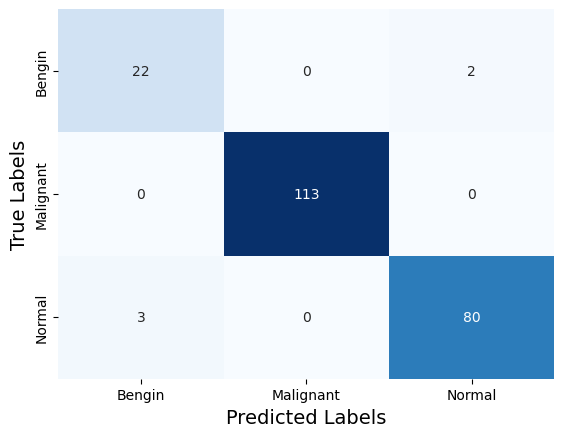

CPU times: total: 19min 19s
Wall time: 20min 7s


In [35]:
%%time
from tensorflow.keras.applications import MobileNetV2

#15 or 25
model_name = 'mobilenetv2'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_mobilenetv2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_mobilenetv2 = build_model_mobilenetv2()
model_mobilenetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_mobilenetv2 = model_mobilenetv2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_mobilenetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_mobilenetv2.history['loss'], color='silver', label='loss')
plt.plot(history_mobilenetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_mobilenetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### DenseNet 121, 169, 201

#### DenseNet 121

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,094,275 (30.88 MB)

 Trainable params: 1,222,851 (4.66 MB)

 Non-trainable params: 6,871,424 (26.21 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 802ms/step - accuracy: 0.7469 - loss: 0.7140 - val_accuracy: 0.8310 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 757ms/step - accuracy: 0.9520 - loss: 0.1559 - val_accuracy: 0.9310 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 773ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9690 - val_loss: 0.0956 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 741ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9724 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 741ms/step - accuracy: 0.9987 - loss: 0.0065 - val_accuracy: 0.9690 - val_loss: 0.1510 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 744ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9793 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 739ms/step - accuracy: 1.0000 - loss: 0.

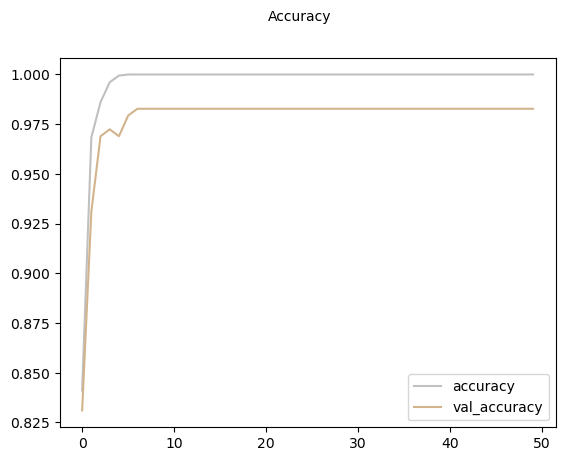

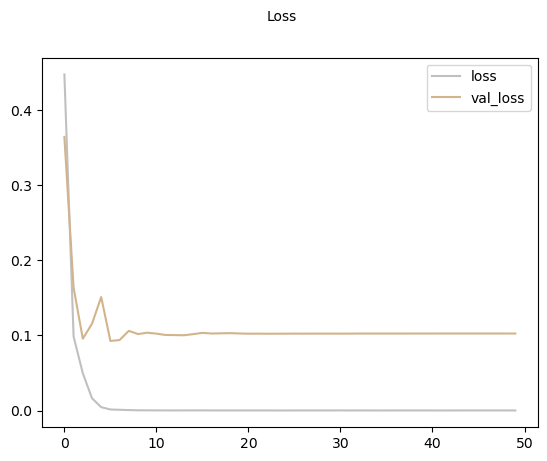

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step
              precision    recall  f1-score   support

           0     1.0000    0.7083    0.8293        24
           1     0.9826    1.0000    0.9912       113
           2     0.9318    0.9880    0.9591        83

    accuracy                         0.9636       220
   macro avg     0.9715    0.8988    0.9265       220
weighted avg     0.9653    0.9636    0.9614       220

The Cohen's Kappa Score is: 0.9364460332936121


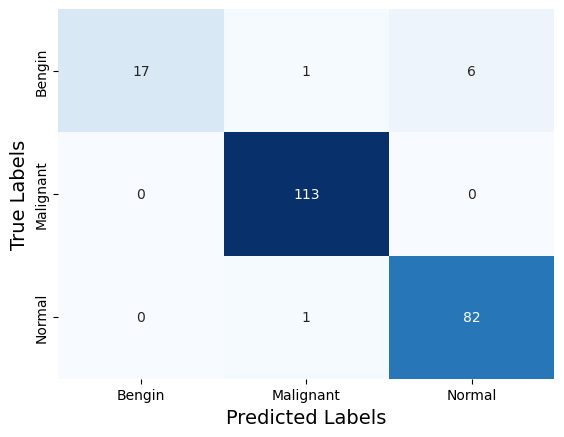

CPU times: total: 21min 20s
Wall time: 35min 43s


In [54]:
%%time
from tensorflow.keras.applications import DenseNet121

model_name = 'densenet121'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet121():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet121 = build_model_DenseNet121()
model_DenseNet121.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet121 = model_DenseNet121.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet121.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet121.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet121.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet121.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet121.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### DenseNet1 169

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 14,355,011 (54.76 MB)

 Trainable params: 1,962,691 (7.49 MB)

 Non-trainable params: 12,392,320 (47.27 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 389ms/step - accuracy: 0.7542 - loss: 0.7010 - val_accuracy: 0.9345 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 399ms/step - accuracy: 0.9621 - loss: 0.1133 - val_accuracy: 0.8448 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 395ms/step - accuracy: 0.9644 - loss: 0.0828 - val_accuracy: 0.9345 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 396ms/step - accuracy: 0.9901 - loss: 0.0308 - val_accuracy: 0.9552 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.9957 - loss: 0.0167 - val_accuracy: 0.9621 - val_loss: 0.1554 - learning_rate: 5.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 396ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9690 - val_loss: 0.1824 - learning_rate: 5.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 405ms/step - accur

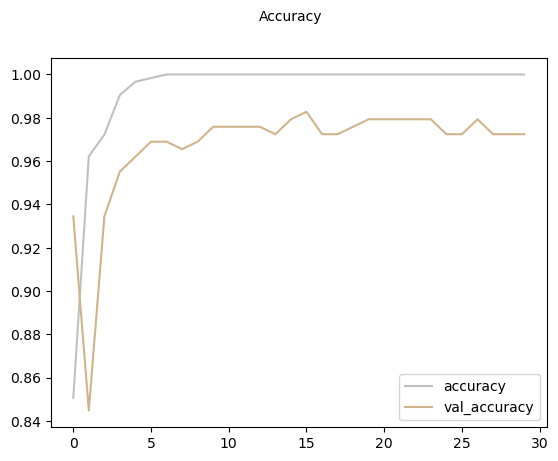

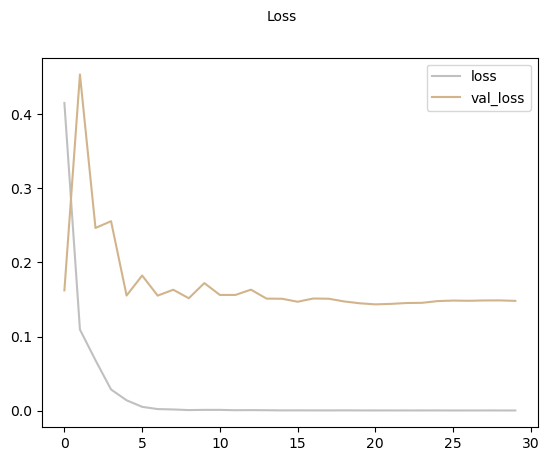

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 986ms/step
              precision    recall  f1-score   support

           0     0.9524    0.8333    0.8889        24
           1     0.9912    1.0000    0.9956       113
           2     0.9647    0.9880    0.9762        83

    accuracy                         0.9773       220
   macro avg     0.9694    0.9404    0.9536       220
weighted avg     0.9770    0.9773    0.9766       220

The Cohen's Kappa Score is: 0.9606566758467756


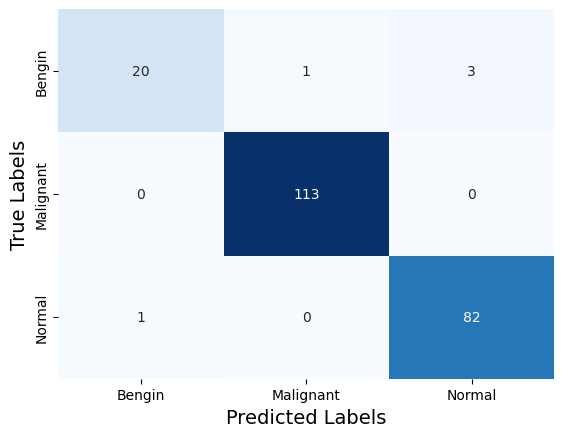

CPU times: total: 15min 22s
Wall time: 22min 23s


In [39]:
%%time
from tensorflow.keras.applications import DenseNet169

model_name = 'densenet169'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet169():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet169 = build_model_DenseNet169()
model_DenseNet169.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet169 = model_DenseNet169.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet169.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet169.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet169.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet169.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet169.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### DenseNet 201

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,296,259 (77.42 MB)

 Trainable params: 2,258,627 (8.62 MB)

 Non-trainable params: 18,037,632 (68.81 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7583 - loss: 0.7620 - val_accuracy: 0.7034 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9686 - loss: 0.0872 - val_accuracy: 0.9379 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.8655 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9954 - loss: 0.0217 - val_accuracy: 0.9345 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9997 - loss: 0.0079 - val_accuracy: 0.9655 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9655 - val_loss: 0.1699 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 

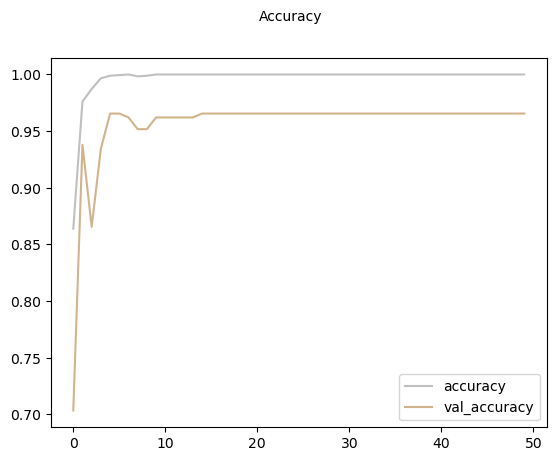

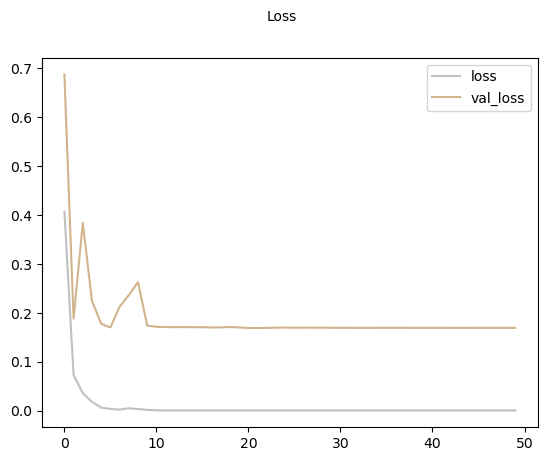

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
              precision    recall  f1-score   support

           0     0.9474    0.7500    0.8372        24
           1     0.9912    1.0000    0.9956       113
           2     0.9310    0.9759    0.9529        83

    accuracy                         0.9636       220
   macro avg     0.9565    0.9086    0.9286       220
weighted avg     0.9637    0.9636    0.9622       220

The Cohen's Kappa Score is: 0.9367838798893717


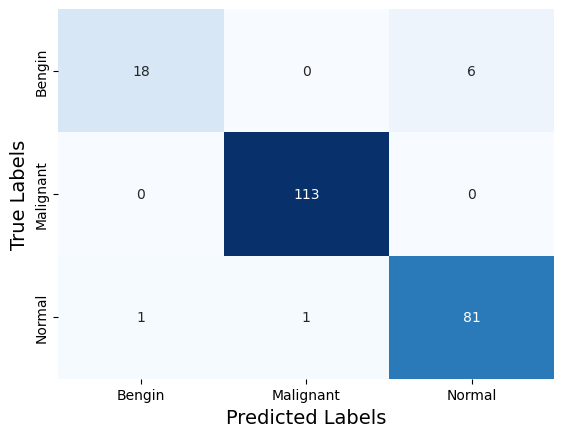

CPU times: total: 35min 19s
Wall time: 53min 43s


In [49]:
%%time
from tensorflow.keras.applications import DenseNet201

model_name = 'densenet201'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet201():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet201 = build_model_DenseNet201()
model_DenseNet201.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet201 = model_DenseNet201.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet201.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet201.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet201.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet201.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet201.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using Model Soup Basic-L

# Hyperparameter tuning

In [27]:
%%time
# using grid search

hyper_param = {
    'optimizer': ['adam'],
    'batch_size': [16, 32],
    'epochs': [10, 20, 25] 
}

def build_model_cnn(optimizer="adam", dropout_rate=0.2):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(x_train_smt.shape[1:])))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    return model

model_cnn_wrap = KerasClassifier(build_fn=build_model_cnn)

grid_search = GridSearchCV(estimator=model_cnn_wrap, param_grid=hyper_param, cv=3)
grid_search_result = grid_search.fit(x_train_smt, y_train_smt)
print("Best Parameters:", grid_search_result.best_params_)
print("Best Score:", grid_search_result.best_score_)

Epoch 1/10


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 705ms/step - accuracy: 0.4731 - loss: 1.3803
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.8687 - loss: 0.3530
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9518 - loss: 0.1022
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 800ms/step - accuracy: 0.9941 - loss: 0.0215
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 756ms/step - accuracy: 0.9805 - loss: 0.0699
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step - accuracy: 0.9953 - loss: 0.0160
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 754ms/step - accuracy: 0.9989 - loss: 0.0062
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 755ms/step - accuracy: 0.9980 - loss: 0.0100
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 721ms/step - accuracy: 0.9977 - loss: 0.0160
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 753ms/step - accuracy: 0.9964 - loss: 0.0082
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
Epoch 1/10


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 744ms/step - accuracy: 0.4946 - loss: 1.6966
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 759ms/step - accuracy: 0.9048 - loss: 0.3168
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 763ms/step - accuracy: 0.9900 - loss: 0.0471
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 791ms/step - accuracy: 0.9936 - loss: 0.0174
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 740ms/step - accuracy: 0.9946 - loss: 0.0120
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 765ms/step - accuracy: 0.9565 - loss: 0.1211
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 762ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 727ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 780ms/step - accuracy: 1.0000 - loss: 2.9043e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
Epoch 1/10


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 793ms/step - accuracy: 0.5464 - loss: 1.2932
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 751ms/step - accuracy: 0.8957 - loss: 0.3700
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.9698 - loss: 0.0982
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 777ms/step - accuracy: 0.9909 - loss: 0.0366
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 734ms/step - accuracy: 0.9928 - loss: 0.0208
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 753ms/step - accuracy: 0.9969 - loss: 0.0200
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - accuracy: 0.9911 - loss: 0.0287
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 704ms/step - accuracy: 0.9936 - loss: 0.0249
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9915 - loss: 0.0242
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9997 - loss: 0.0021
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step
Epoch 1/20


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - accuracy: 0.4534 - loss: 2.3928
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 760ms/step - accuracy: 0.7927 - loss: 0.4623
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 806ms/step - accuracy: 0.9615 - loss: 0.1209
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 727ms/step - accuracy: 0.9730 - loss: 0.0803
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - accuracy: 0.9825 - loss: 0.0419
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 732ms/step - accuracy: 0.9743 - loss: 0.0584
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 760ms/step - accuracy: 0.9814 - loss: 0.0356
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 736ms/step - accuracy: 0.9975 - loss: 0.0270
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step - accuracy: 0.9914 - loss: 0.0220
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.9918 - loss: 0.0198
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step - accuracy: 0.9865 - loss: 0.0492
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 712ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 748ms/step - accuracy: 0.4088 - loss: 1.8496
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 744ms/step - accuracy: 0.7081 - loss: 0.6837
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9298 - loss: 0.2074
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 785ms/step - accuracy: 0.9774 - loss: 0.0740
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 733ms/step - accuracy: 0.9878 - loss: 0.0327
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 751ms/step - accuracy: 0.9920 - loss: 0.0237
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - accuracy: 0.9910 - loss: 0.0178
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.9982 - loss: 0.0109
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 754ms/step - accuracy: 0.9908 - loss: 0.0192
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 750ms/step - accuracy: 0.9948 - loss: 0.0179
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 745ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 750ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 789ms/step - accuracy: 0.5299 - loss: 1.2884
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 737ms/step - accuracy: 0.8118 - loss: 0.4876
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step - accuracy: 0.8797 - loss: 0.2638
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 763ms/step - accuracy: 0.9640 - loss: 0.1231
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/step - accuracy: 0.9802 - loss: 0.0736
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.9763 - loss: 0.0907
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 764ms/step - accuracy: 0.9858 - loss: 0.0577
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step - accuracy: 0.9980 - loss: 0.0224
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 721ms/step - accuracy: 0.9975 - loss: 0.0164
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step - accuracy: 0.9932 - loss: 0.0081
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 756ms/step - accuracy: 0.9984 - loss: 0.0029
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 786ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 730ms/step - accuracy: 0.4939 - loss: 1.3343
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 797ms/step - accuracy: 0.9097 - loss: 0.2396
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 757ms/step - accuracy: 0.9641 - loss: 0.0875
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 749ms/step - accuracy: 0.9844 - loss: 0.0466
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 759ms/step - accuracy: 0.9786 - loss: 0.0879
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 775ms/step - accuracy: 0.9998 - loss: 0.0093
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 767ms/step - accuracy: 0.9951 - loss: 0.0104
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 765ms/step - accuracy: 0.9932 - loss: 0.0297
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 775ms/step - accuracy: 0.9717 - loss: 0.0785
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 754ms/step - accuracy: 0.9912 - loss: 0.0421
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 773ms/step - accuracy: 0.9849 - loss: 0.0272
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 755ms/step - accuracy: 0.4509 - loss: 1.6857
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/step - accuracy: 0.8234 - loss: 0.4237
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9750 - loss: 0.0795
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 787ms/step - accuracy: 0.9919 - loss: 0.0292
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 764ms/step - accuracy: 0.9987 - loss: 0.0115
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - accuracy: 0.9913 - loss: 0.0142
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 763ms/step - accuracy: 0.9894 - loss: 0.0346
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step - accuracy: 0.9878 - loss: 0.0287
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 738ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 768ms/step - accuracy: 0.9990 - loss: 0.0082
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 764ms/step - accuracy: 0.9966 - loss: 0.0151
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 801ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 765ms/step - accuracy: 0.5817 - loss: 1.6828
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 773ms/step - accuracy: 0.9253 - loss: 0.2770
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - accuracy: 0.9685 - loss: 0.0892
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.9819 - loss: 0.0625
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 775ms/step - accuracy: 0.9755 - loss: 0.0842
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 786ms/step - accuracy: 0.9901 - loss: 0.0453
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 740ms/step - accuracy: 0.9898 - loss: 0.0256
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step - accuracy: 0.9901 - loss: 0.0343
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 794ms/step - accuracy: 0.9973 - loss: 0.0086
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 756ms/step - accuracy: 0.9987 - loss: 0.0048
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 744ms/step - accuracy: 0.9965 - loss: 0.0171
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/ste

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3510 - loss: 1.6048
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6487 - loss: 0.7793
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7904 - loss: 0.4432
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9176 - loss: 0.2214
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9737 - loss: 0.0748
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9683 - loss: 0.0971
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9972 - loss: 0.0160
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9991 - loss: 0.0043
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9924 - loss: 0.0374
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9978 - loss: 0.0073
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3856 - loss: 2.1289
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7011 - loss: 0.7297
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8752 - loss: 0.3770
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9518 - loss: 0.1321
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9633 - loss: 0.0903
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9890 - loss: 0.0283
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 1.0000 - loss: 0.0098
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9992 - loss: 0.0062
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9986 - loss: 0.0057
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 0.0011
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step
Epoch 1/10


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5257 - loss: 1.8578
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7671 - loss: 0.6286
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9025 - loss: 0.3625
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9168 - loss: 0.2174
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9671 - loss: 0.0920
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9876 - loss: 0.0365
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9940 - loss: 0.0300
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9957 - loss: 0.0140
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9907 - loss: 0.0303
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9979 - loss: 0.0096
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step
Epoch 1/20


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4058 - loss: 2.4034
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7595 - loss: 0.5574
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9489 - loss: 0.1962
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9810 - loss: 0.0688
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9771 - loss: 0.0604
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9914 - loss: 0.0334
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9992 - loss: 0.0164
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9990 - loss: 0.0114
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9905 - loss: 0.0255
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9900 - loss: 0.0486
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9787 - loss: 0.0550
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9985 - loss: 0.0112


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4250 - loss: 1.4667
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6965 - loss: 0.7010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8850 - loss: 0.3134
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9657 - loss: 0.1260
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9896 - loss: 0.0372
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9864 - loss: 0.0518
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9901 - loss: 0.0241
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9977 - loss: 0.0117
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9825 - loss: 0.0510
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9908 - loss: 0.0253
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9941 - loss: 0.0184
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9921 - loss: 0.0208


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4818 - loss: 2.8069
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6535 - loss: 0.7313
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8075 - loss: 0.5006
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8661 - loss: 0.3409
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9338 - loss: 0.1946
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9454 - loss: 0.1409
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9785 - loss: 0.0705
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9802 - loss: 0.0789
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9930 - loss: 0.0336
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9946 - loss: 0.0174
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9960 - loss: 0.0126
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9942 - loss: 0.0217


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4338 - loss: 1.7912
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6485 - loss: 0.7929
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8512 - loss: 0.3523
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9603 - loss: 0.1410
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9863 - loss: 0.0581
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9907 - loss: 0.0380
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9898 - loss: 0.0396
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9806 - loss: 0.0388
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9932 - loss: 0.0178
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9983 - loss: 0.0069
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9837 - loss: 0.0274
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9904 - loss: 0.0238


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4316 - loss: 2.3694
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7630 - loss: 0.5625
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9296 - loss: 0.1480
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9719 - loss: 0.0824
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9931 - loss: 0.0338
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9912 - loss: 0.0236
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9987 - loss: 0.0114
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9979 - loss: 0.0169
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9961 - loss: 0.0110
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 5.9326e-04
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 4.1

C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5005 - loss: 2.2741
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6861 - loss: 0.7269
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8608 - loss: 0.3486
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9436 - loss: 0.1269
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9827 - loss: 0.0542
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9768 - loss: 0.0617
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9967 - loss: 0.0162
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9923 - loss: 0.0190
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9931 - loss: 0.0153
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9886 - loss: 0.0246
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9940 - loss: 0.0352
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9988 - loss: 0.0112


C:\Users\ivans\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 771ms/step - accuracy: 0.4633 - loss: 1.2089
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 760ms/step - accuracy: 0.9283 - loss: 0.2377
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 789ms/step - accuracy: 0.9792 - loss: 0.0681
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 753ms/step - accuracy: 0.9947 - loss: 0.0381
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 794ms/step - accuracy: 0.9939 - loss: 0.0210
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 801ms/step - accuracy: 0.9988 - loss: 0.0046
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 783ms/step - accuracy: 0.9868 - loss: 0.0285
Epoch 8/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 995ms/step - accuracy: 0.9957 - loss: 0.0190
Epoch 9/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 806ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 10/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 769ms/step - accuracy: 1.0000 - loss: 8.4739e-04
Epoch 11/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 750ms/step - accuracy: 0.9989 - loss: 0.0039
Epoch 12/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 780ms

C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 254, 254, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,969,283 (57.10 MB)

 Trainable params: 14,969,283 (57.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 784ms/step - accuracy: 0.4799 - loss: 3.1973 - val_accuracy: 0.8241 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 825ms/step - accuracy: 0.8453 - loss: 0.6796 - val_accuracy: 0.9069 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - accuracy: 0.9520 - loss: 0.4067 - val_accuracy: 0.7655 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 852ms/step - accuracy: 0.9281 - loss: 0.5230 - val_accuracy: 0.9276 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 869ms/step - accuracy: 0.9763 - loss: 0.2905 - val_accuracy: 0.9069 - val_loss: 0.5051 - learning_rate: 0.0010
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 817ms/step - accuracy: 0.9596 - loss: 0.2995 - val_accuracy: 0.8414 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 840ms/step - accuracy: 0.9807 - loss: 0.

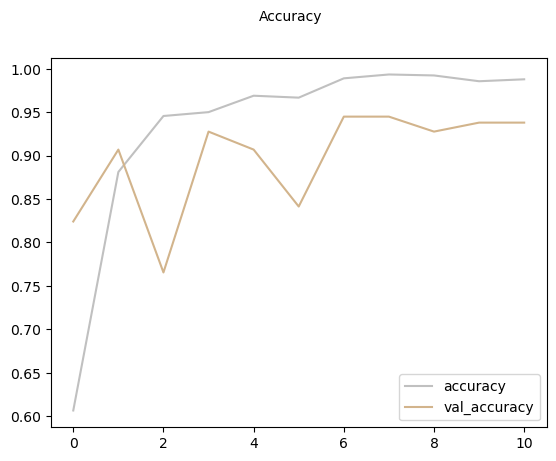

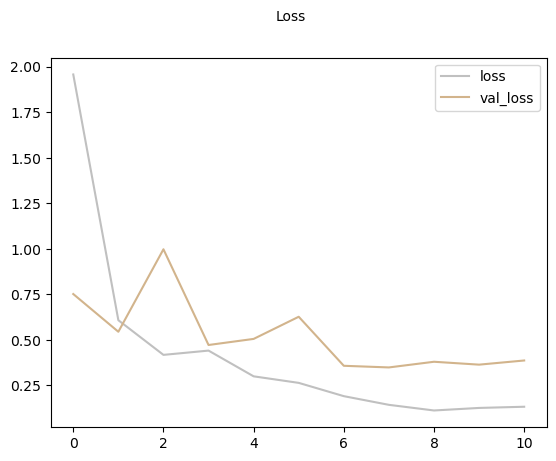

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.95      0.97      0.96       113
           2       0.96      0.93      0.94        83

    accuracy                           0.96       220
   macro avg       0.97      0.97      0.97       220
weighted avg       0.96      0.96      0.96       220

The Cohen's Kappa Score is: 0.9294771334947999


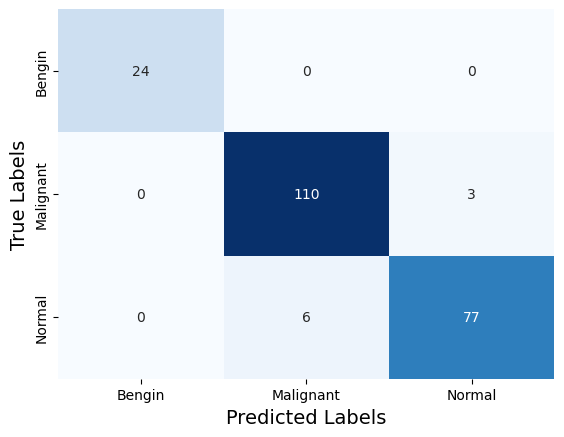

CPU times: total: 1h 57min 36s
Wall time: 8min 48s


In [33]:
%%time
#'batch_size': 16, 'epochs': 25, 'optimizer': 'adam'
# cnn model

def build_model_cnn(optimizer="adam", dropout_rate=0.2):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(x_train_smt.shape[1:])))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    return model

model_cnn = build_model_cnn()
model_cnn.summary()

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model fitting
history_cnn = model_cnn.fit(x_train_smt, y_train_smt, batch_size = 16, epochs = 25, validation_data = (x_val, y_val), callbacks=[lr_scheduler, early_stopping, tensorboard_callback])

# show graphs of accuracy and loss
fig = plt.figure()
plt.plot(history_cnn.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='silver', label='loss')
plt.plot(history_cnn.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_cnn.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels)